In [1]:
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import os,cv2
import time

2023-07-13 15:17:40.243749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_path = "dog_cat/training_set/"
test_path = "dog_cat/test_set/"

img_size = 128

def get_data(path):
    data = []
    for filename in os.listdir(path):
        category = filename.split('.')[0]
        if category == 'dog':
            try:
                img_arr = cv2.imread(os.path.join(path,filename), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr,(img_size,img_size))
                data.append([resized_arr, 1])
            except Exception as e:
                print(e)
        else:
            try:
                img_arr = cv2.imread(os.path.join(path,filename), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr,(img_size,img_size))
                data.append([resized_arr, 0])
            except Exception as e:
                print(e)
    return data

train = get_data(train_path)
test = get_data(test_path)



OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [3]:
import numpy as np
print(np.array(train,dtype='object').shape)
print(np.array(test,dtype='object').shape)

(8005, 2)
(2023, 2)


In [4]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label) 
print(np.array(x_train).shape)

#print test array
for feature, label in test:
    x_test.append(feature)
    y_test.append(label) 
print(np.array(x_test).shape)
  
del train
del test

(8005, 128, 128, 3)
(2023, 128, 128, 3)


In [5]:
# # Normalize the data
import random as rn
x_train = np.array(x_train,dtype="float")/255.0
x_test = np.array(x_test,dtype="float")/255.0

# #label encoding the y array
y_train = to_categorical(y_train, 2) 
y_test = to_categorical(y_test, 2)

#Prepare data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True, random_state=42)

np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

print(x_val.shape)

(1601, 128, 128, 3)


In [6]:
# This CNN architecture refers to the below link but the optimizer will change to Adam:
# https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [7]:
datagen = ImageDataGenerator(        
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images)

datagen.fit(x_train)

# validgen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images)
# validgen.fit(x_val)

In [8]:
model = create_model()
# model.summary()

2023-07-13 15:17:58.853761: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-13 15:17:58.854547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-13 15:17:58.882295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-13 15:17:58.882317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-13 15:17:58.884878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-13 15:17:58.884918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [9]:
start_time = time.time()
batch_size=32
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("dogcat_model.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs = 50, validation_data = (x_val,y_val), callbacks=[checkpoint, early],
                    verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
#history = model.fit(x_train, y_train, epochs = 50, validation_data = (x_val,y_val), callbacks=[checkpoint, early],verbose = 1)
model.save("dogcat_model.h5")
end_time = time.time()
print("time: ",end_time-start_time)

2023-07-13 15:17:59.745938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-13 15:17:59.758062: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700000000 Hz


Epoch 1/50


2023-07-13 15:18:00.279742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-13 15:18:00.410908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-07-13 15:18:01.050345: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-07-13 15:18:01.078026: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 23s 93ms/step - loss: 1.2829 - accuracy: 0.5624 - val_loss: 1.0353 - val_accuracy: 0.4859

Epoch 00001: val_accuracy improved from -inf to 0.48595, saving model to dogcat_model.h5
Epoch 2/50
200/200 [==============================] - 14s 69ms/step - loss: 0.7375 - accuracy: 0.6126 - val_loss: 0.9286 - val_accuracy: 0.5240

Epoch 00002: val_accuracy improved from 0.48595 to 0.52405, saving model to dogcat_model.h5
Epoch 3/50
200/200 [==============================] - 14s 70ms/step - loss: 0.6585 - accuracy: 0.6373 - val_loss: 0.7812 - val_accuracy: 0.5928

Epoch 00003: val_accuracy improved from 0.52405 to 0.59275, saving model to dogcat_model.h5
Epoch 4/50
200/200 [==============================] - 14s 70ms/step - loss: 0.6372 - accuracy: 0.6442 - val_loss: 0.5969 - val_accuracy: 0.6833

Epoch 00004: val_accuracy improved from 0.59275 to 0.68332, saving model to dogcat_model.h5
Epoch 5/50
200/200 [==============================] - 14s 70ms/ste

In [10]:
_,acc = model.evaluate(x_test, y_test, verbose=0)
print('test:',acc)
_,acc = model.evaluate(x_train, y_train, verbose=0)
print('train:',acc)
_,acc = model.evaluate(x_val, y_val, verbose=0)
print('val:',acc)

test: 0.8269895911216736
train: 0.8366645574569702
val: 0.8176140189170837


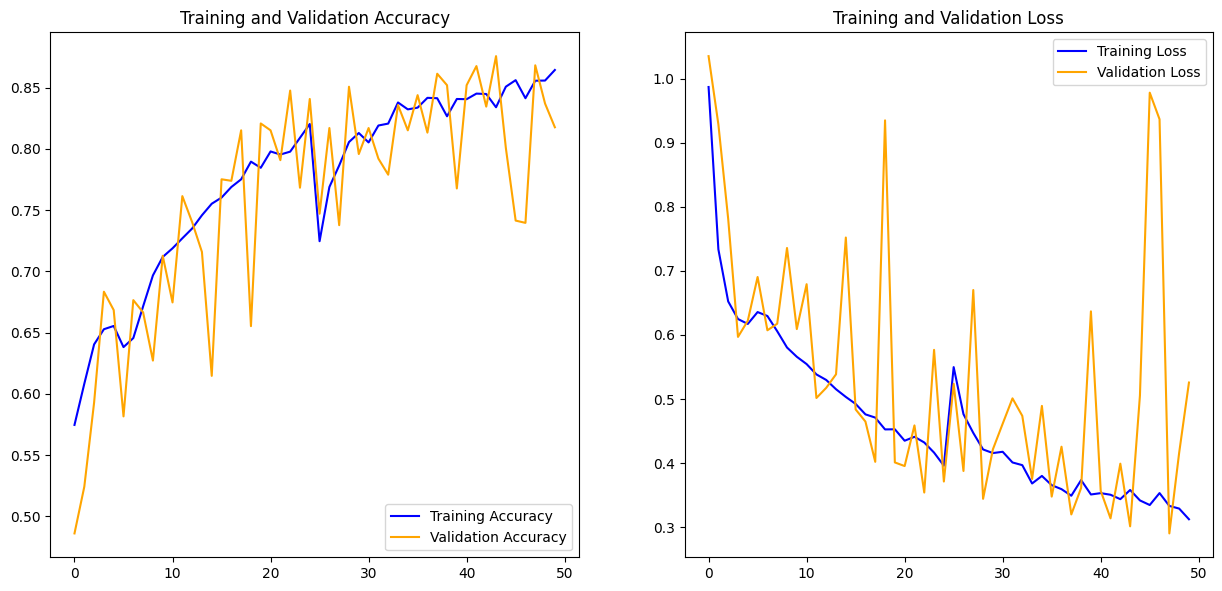

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


pyplot.figure(figsize=(15, 15))
pyplot.subplot(2, 2, 1)
pyplot.plot(acc, color="blue", label='Training Accuracy')
pyplot.plot(val_acc, color="orange", label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(2, 2, 2)
pyplot.plot(loss, color="blue", label='Training Loss')
pyplot.plot(val_loss, color="orange", label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()


In [12]:
# model1 = load_model("dogcat_model.h5")
# model1_last_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
# model1_last_layer_output_train = model1_last_layer_output.predict(x_train, batch_size=32)
# model1_last_layer_output_val = model1_last_layer_output.predict(x_val, batch_size=32)
# model1_last_layer_output_test = model1_last_layer_output.predict(x_test, batch_size=32)


# model2 = Sequential()

# model2.add(Dense(2, activation='softmax'))
#     # compile model
# model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
# checkpoint = ModelCheckpoint("dogcat_model2.h5", monitor='val_accuracy', verbose=1, 
#                              save_best_only=True, save_weights_only=False, mode='auto')

# model2.fit(model1_last_layer_output_train, y_train, epochs=50, validation_data=(model1_last_layer_output_val, y_val),callbacks=[checkpoint, early], batch_size=32)


# _,acc = model2.evaluate(model1_last_layer_output_test, y_test, verbose=0)
# print("test:",acc)
# _, acc = model2.evaluate(model1_last_layer_output_train, y_train, verbose=0)
# print("train:",acc)
# _,acc = model2.evaluate(model1_last_layer_output_val, y_val, verbose=0)
# print("val:",acc)


# del model1_last_layer_output_train
# del model1_last_layer_output_val
# del model1_last_layer_output_test
# del model1, model2
# tf.keras.backend.clear_session()

In [13]:
model1 = load_model("dogcat_model.h5")
model1_last_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
model1_last_layer_output_train = model1_last_layer_output.predict(x_train, batch_size=32)
model1_last_layer_output_val = model1_last_layer_output.predict(x_val, batch_size=32)
model1_last_layer_output_test = model1_last_layer_output.predict(x_test, batch_size=32)


model2 = Sequential()

model2.add(Dense(2, activation='softmax'))
    # compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("dogcat_model3.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
stime = time.time()
model2.fit(model1_last_layer_output_train, y_train, epochs=50, validation_data=(model1_last_layer_output_val, y_val),callbacks=[checkpoint, early], batch_size=32)
etime = time.time()

_,acc = model2.evaluate(model1_last_layer_output_test, y_test, verbose=0)
print("test:",acc)
_, acc = model2.evaluate(model1_last_layer_output_train, y_train, verbose=0)
print("train:",acc)
_,acc = model2.evaluate(model1_last_layer_output_val, y_val, verbose=0)
print("val:",acc)
print("time: ",etime-stime)

del model1_last_layer_output_train
del model1_last_layer_output_val
del model1_last_layer_output_test
del model1, model2
tf.keras.backend.clear_session()

Epoch 1/50
201/201 [==============================] - 0s 1ms/step - loss: 0.3752 - accuracy: 0.8225 - val_loss: 0.3006 - val_accuracy: 0.8738

Epoch 00001: val_accuracy improved from -inf to 0.87383, saving model to dogcat_model3.h5
Epoch 2/50
201/201 [==============================] - 0s 913us/step - loss: 0.2219 - accuracy: 0.9099 - val_loss: 0.2946 - val_accuracy: 0.8795

Epoch 00002: val_accuracy improved from 0.87383 to 0.87945, saving model to dogcat_model3.h5
Epoch 3/50
201/201 [==============================] - 0s 908us/step - loss: 0.1987 - accuracy: 0.9228 - val_loss: 0.2937 - val_accuracy: 0.8807

Epoch 00003: val_accuracy improved from 0.87945 to 0.88070, saving model to dogcat_model3.h5
Epoch 4/50
201/201 [==============================] - 0s 915us/step - loss: 0.1763 - accuracy: 0.9314 - val_loss: 0.2852 - val_accuracy: 0.8832

Epoch 00004: val_accuracy improved from 0.88070 to 0.88320, saving model to dogcat_model3.h5
Epoch 5/50
201/201 [==============================] -

In [14]:
model1 = load_model("dogcat_model.h5")
model1_last_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
model1_last_layer_output_train = model1_last_layer_output.predict(x_train, batch_size=32)
model1_last_layer_output_val = model1_last_layer_output.predict(x_val, batch_size=32)
model1_last_layer_output_test = model1_last_layer_output.predict(x_test, batch_size=32)


model2 = Sequential()
model2.add(Dense(2, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("dogcat_model4.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')

model2.fit(model1_last_layer_output_train, y_train, epochs=50, validation_data=(model1_last_layer_output_val, y_val), callbacks=[checkpoint, early], batch_size=32)


_,acc = model2.evaluate(model1_last_layer_output_test, y_test, verbose=0)
print("test:",acc)
_, acc = model2.evaluate(model1_last_layer_output_train, y_train, verbose=0)
print("train:",acc)
_,acc = model2.evaluate(model1_last_layer_output_val, y_val, verbose=0)
print("val:",acc)

del model1_last_layer_output
del model1_last_layer_output_train
del model1_last_layer_output_val
del model1_last_layer_output_test
del model1
tf.keras.backend.clear_session()

Epoch 1/50
201/201 [==============================] - 0s 1ms/step - loss: 0.3833 - accuracy: 0.8251 - val_loss: 0.3068 - val_accuracy: 0.8732

Epoch 00001: val_accuracy improved from -inf to 0.87320, saving model to dogcat_model4.h5
Epoch 2/50
201/201 [==============================] - 0s 923us/step - loss: 0.2281 - accuracy: 0.9013 - val_loss: 0.3013 - val_accuracy: 0.8788

Epoch 00002: val_accuracy improved from 0.87320 to 0.87883, saving model to dogcat_model4.h5
Epoch 3/50
201/201 [==============================] - 0s 929us/step - loss: 0.2101 - accuracy: 0.9129 - val_loss: 0.2962 - val_accuracy: 0.8757

Epoch 00003: val_accuracy did not improve from 0.87883
Epoch 4/50
201/201 [==============================] - 0s 923us/step - loss: 0.1822 - accuracy: 0.9245 - val_loss: 0.2920 - val_accuracy: 0.8801

Epoch 00004: val_accuracy improved from 0.87883 to 0.88007, saving model to dogcat_model4.h5
Epoch 5/50
201/201 [==============================] - 0s 930us/step - loss: 0.1974 - accura